In [10]:
# 라이브러리 임포트
# 세션 변경으로 GPU 설정

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [11]:
# 1. 데이터 로드 함수 (CNN과 동일)

# 파일 로드 함수
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# 그룹 로드
def load_group(filenames, prefix=''):
    loaded = [load_file(prefix + name) for name in filenames]
    return np.dstack(loaded)

# train/test 그룹 데이터셋 로드
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        # total acceleration
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        # body acceleration
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        # body gyroscope
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# 전체 데이터 로드
def load_dataset(prefix=''):
    dataset_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로그래밍/10주/UCI HAR Dataset/'
    trainX, trainy = load_dataset_group('train', dataset_path)
    testX, testy = load_dataset_group('test', dataset_path)

    # 0부터 시작하도록 조정
    trainy, testy = trainy - 1, testy - 1

    # One-hot encoding
    trainy_one_hot, testy_one_hot = to_categorical(trainy), to_categorical(testy)

    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

# 2. 데이터 불러오기 및 분할

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy,
    test_size=0.2,
    random_state=100
)

print(X_train.shape, X_val.shape, y_train_one_hot.shape, y_val_one_hot.shape)

/tmp/ipython-input-656891497.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-656891497.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-656891497.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-656891497.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp

(7352, 128, 9) (7352, 1) (2947, 128, 9) (2947, 1)
(5881, 128, 9) (1471, 128, 9) (5881, 6) (1471, 6)


/tmp/ipython-input-656891497.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [14]:
# 3. CNN + LSTM 모델 정의

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

cnn_lstm_model = Sequential([
    # --- CNN 부분 ---
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # --- LSTM 부분 ---
    LSTM(64, return_sequences=False),
    Dropout(0.3),

    # --- 출력층 ---
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

cnn_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn_lstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 126, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,622 (154.77 KB)

 Trainable params: 39,494 (154.27 KB)

 Non-trainable params: 128 (512.00 B)

In [15]:
# 4. 모델 학습

history = cnn_lstm_model.fit(
    X_train, y_train_one_hot,
    epochs=30,
    batch_size=64,
    validation_data=(X_val, y_val_one_hot),
    verbose=1
)

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5378 - loss: 1.2205 - val_accuracy: 0.3644 - val_loss: 2.3711
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8864 - loss: 0.3485 - val_accuracy: 0.7179 - val_loss: 1.2952
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9252 - loss: 0.2121 - val_accuracy: 0.8375 - val_loss: 0.8243
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9389 - loss: 0.1551 - val_accuracy: 0.8919 - val_loss: 0.3026
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9394 - loss: 0.1523 - val_accuracy: 0.9341 - val_loss: 0.1912
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9503 - loss: 0.1332 - val_accuracy: 0.9409 - val_loss: 0.1488
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9486 - loss: 0.1308 - val_accuracy: 0.9449 - val_loss: 0.1346
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9541 - loss: 0.1259 - val_accuracy: 0.9490 - v

In [16]:
# 5. 평가

loss, acc = cnn_lstm_model.evaluate(testX, testy_one_hot, verbose=0)
print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.9165


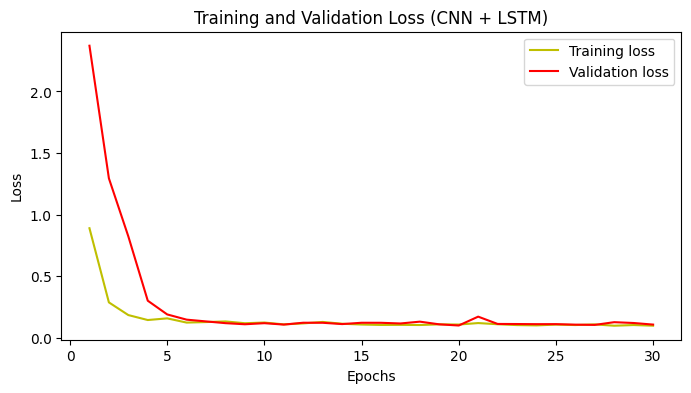

In [18]:
# 6. 학습 결과 시각화

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# 손실 그래프

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss (CNN + LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

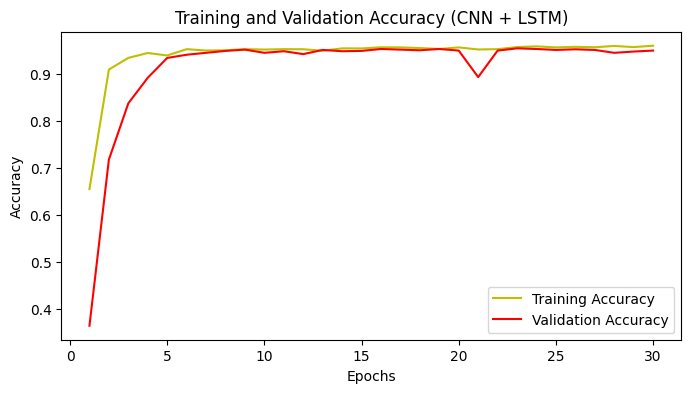

In [19]:
# 정확도 그래프

plt.figure(figsize=(8, 4))
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy (CNN + LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
✅ Test Accuracy: 0.9165252799457075

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       496
           1       0.98      0.92      0.95       471
           2       0.95      1.00      0.97       420
           3       0.76      0.86      0.81       491
           4       0.87      0.76      0.81       532
           5       1.00      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



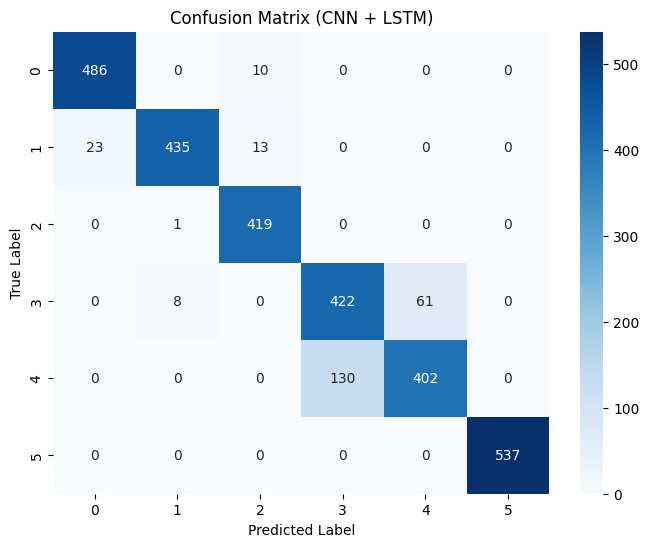

In [20]:
# 7. 예측 및 혼동행렬

pred = cnn_lstm_model.predict(testX)
pred = np.argmax(pred, axis=-1)
true = np.argmax(testy_one_hot, axis=-1)

print("✅ Test Accuracy:", accuracy_score(true, pred))
print("\n📊 Classification Report:\n", classification_report(true, pred))

cm = confusion_matrix(true, pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (CNN + LSTM)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()